In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import spikeinterface.full as si

In [3]:
zigzag_rigid = [{'drift_mode': 'zigzag', 
              'non_rigid_gradient': None, 
              't_start_drift': 10.0, 
              't_end_drift': None, 
              'period_s': 500}]

static, drifting, sorting = si.generate_drifting_recording(probe_name='Neuropixel-128', 
                                        seed=23, 
                                        duration=300, 
                                        generate_displacement_vector_kwargs={'motion_list' : zigzag_rigid})

In [4]:
drifting_preprocessed = si.highpass_filter(drifting)
drifting_preprocessed = si.common_reference(drifting_preprocessed, reference='global')

In [8]:
si.set_global_job_kwargs(n_jobs=0.8)
corrected = si.correct_motion(drifting_preprocessed, 
                                        preset='nonrigid_fast_and_accurate', 
                                        interpolate_motion_kwargs={'border_mode' : 'force_extrapolate'},
                                        folder='motion')

detect and localize:   0%|          | 0/120 [00:00<?, ?it/s]

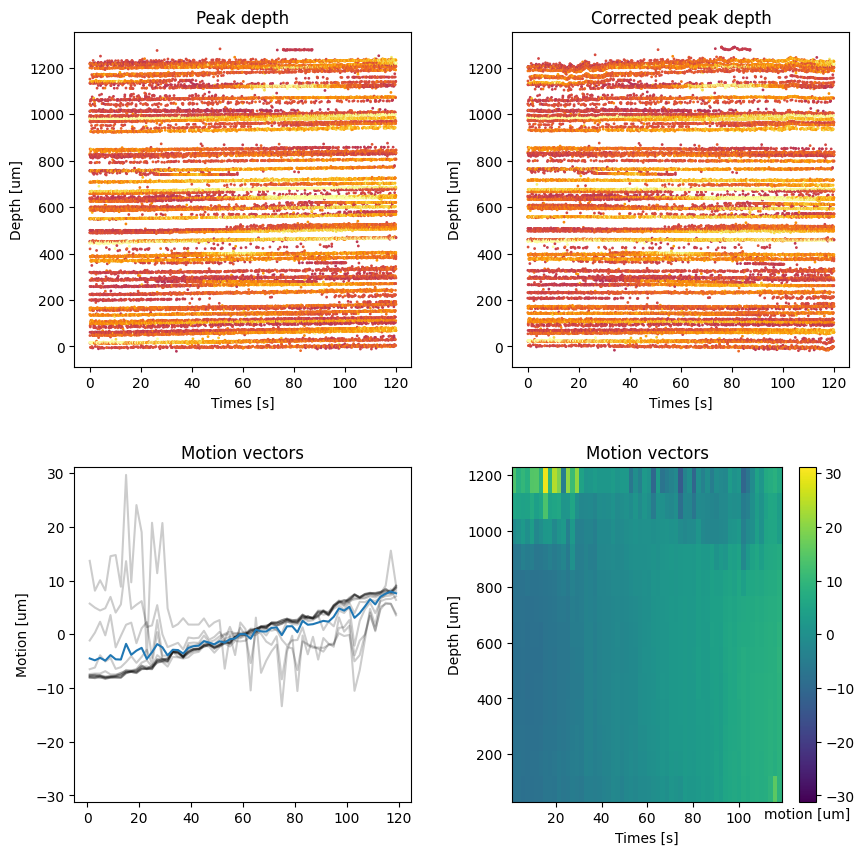

In [9]:
motion_info = si.load_motion_info('motion')
si.plot_motion(motion_info, 
                   corrected, 
                   amplitude_cmap='inferno', 
                   color_amplitude=True, 
                   figsize=(10, 10))

In [98]:
sa = si.create_sorting_analyzer(sorting, corrected)
sa.compute(['random_spikes', 'waveforms', 'templates', 
            'template_similarity', 'unit_locations', 'correlograms', 
            'noise_levels', 'spike_amplitudes'])
si.compute_quality_metrics(sa, metric_names=['snr', 'firing_rate'])

estimate_sparsity:   0%|          | 0/120 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/120 [00:00<?, ?it/s]

Compute : spike_amplitudes:   0%|          | 0/120 [00:00<?, ?it/s]

,firing_rate,snr
0,5.866667,5.180172
1,5.825000,1.622832
2,2.691667,0.630352
3,2.758333,2.811461
4,6.300000,2.472924
...,...,...
245,5.275000,0.165418
246,7.575000,8.148421
247,7.075000,11.729324
248,2.291667,2.544597


In [39]:
%gui qt
si.plot_sorting_summary(sa, backend='spikeinterface_gui')

ERROR:root:module 'PySide6.QtPrintSupport' has no attribute 'QApplication'


In [99]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks
from spikeinterface.core.numpyextractors import NumpySorting
from spikeinterface.core.template_tools import get_template_extremum_channel
extremum_channel_inds = get_template_extremum_channel(sa, outputs="index")
spikes = sa.sorting.to_spike_vector(extremum_channel_inds=extremum_channel_inds)

In [204]:
def split_sorting_by_amplitudes(sa, splitting_probability=0.5):
    if sa.get_extension('spike_amplitudes') is None:
        sa.compute("spike_amplitudes")

    from spikeinterface.core.numpyextractors import NumpySorting
    from spikeinterface.core.template_tools import get_template_extremum_channel
    extremum_channel_inds = get_template_extremum_channel(sa, outputs="index")
    spikes = sa.sorting.to_spike_vector(extremum_channel_inds=extremum_channel_inds)
    new_spikes = spikes.copy()
    amplitudes = sa.get_extension('spike_amplitudes').get_data()
    nb_splits = int(splitting_probability*len(sa.sorting.unit_ids))
    to_split_ids = np.random.choice(sa.sorting.unit_ids, nb_splits, replace=False)
    max_index = np.max(spikes['unit_index'])
    new_unit_ids = list(sa.sorting.unit_ids.copy())
    for unit_id in to_split_ids:
        ind_mask = spikes['unit_index'] == sa.sorting.id_to_index(unit_id)
        m = amplitudes[ind_mask].mean()
        s = amplitudes[ind_mask].std()
        
        amplitude_mask = (amplitudes > m + s)
        mask = ind_mask & amplitude_mask
        new_spikes['unit_index'][mask] = max_index + 1

        amplitude_mask = (amplitudes > m - s) * (amplitudes < m + s)
        mask = ind_mask & amplitude_mask
        new_spikes['unit_index'][mask] = (max_index + 1)*np.random.rand(np.sum(mask)) > 0.5
        
        max_index += 1
        new_unit_ids += [max(new_unit_ids)+1]
        print(unit_id, new_unit_ids[-1])
    new_sorting = NumpySorting(new_spikes, sampling_frequency=sa.sampling_frequency, unit_ids=new_unit_ids)
    return new_sorting

In [205]:
new_sorting = split_sorting_by_amplitudes(sa)
#si.plot_rasters(new_sorting, unit_ids=[150, 250])

143 250
3 251
5 252
207 253
46 254
213 255
44 256
79 257
225 258
245 259
54 260
115 261
34 262
153 263
184 264
118 265
28 266
27 267
199 268
190 269
35 270
249 271
110 272
6 273
138 274
206 275
226 276
11 277
39 278
198 279
152 280
218 281
146 282
62 283
176 284
41 285
162 286
93 287
239 288
22 289
154 290
208 291
99 292
63 293
112 294
211 295
74 296
101 297
14 298
179 299
85 300
91 301
172 302
181 303
80 304
4 305
159 306
128 307
171 308
60 309
49 310
122 311
103 312
8 313
68 314
168 315
127 316
202 317
233 318
66 319
81 320
119 321
24 322
97 323
65 324
45 325
141 326
135 327
149 328
47 329
228 330
194 331
151 332
156 333
189 334
145 335
98 336
147 337
173 338
26 339
197 340
31 341
83 342
230 343
109 344
214 345
221 346
247 347
73 348
72 349
102 350
235 351
10 352
165 353
48 354
19 355
57 356
67 357
157 358
77 359
150 360
240 361
204 362
92 363
61 364
42 365
196 366
167 367
182 368
217 369
137 370
180 371
50 372
136 373
237 374


In [206]:
new_sorting

NumpySorting: 375 units - 1 segments - 30.0kHz

In [207]:
sa2 = si.create_sorting_analyzer(new_sorting, corrected)
sa2.compute(['random_spikes', 'templates', 'waveforms', 'noise_levels', 
             'unit_locations', 'correlograms','spike_amplitudes', 'template_similarity'])
si.compute_quality_metrics(sa2, metric_names=['firing_rate', 'snr'])

estimate_sparsity:   0%|          | 0/120 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/120 [00:00<?, ?it/s]

Compute : spike_amplitudes:   0%|          | 0/120 [00:00<?, ?it/s]

,firing_rate
0,6.491667
1,453.450000
2,2.691667
3,0.433333
4,0.925000
...,...
370,0.683333
371,0.641667
372,0.600000
373,0.516667


In [224]:
a, b = si.get_potential_auto_merge(sa2, minimum_spikes=10, template_metric='cosine', num_channels=5, extra_outputs=True, corr_diff_thresh=1, template_diff_thresh=1)

/home/pierre/github/spikeinterface/src/spikeinterface/curation/auto_merge.py:479: RuntimeWarning: invalid value encountered in scalar divide
  d = 1 - np.sum(temp1 * temp2) / norm


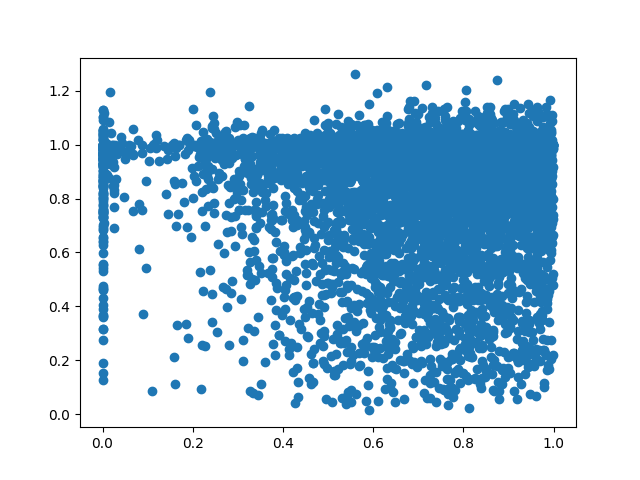

In [241]:
import pylab as plt
plt.close()
plt.scatter(b['correlogram_diff'].flatten(), b['templates_diff'].flatten())
plt.show()